In [31]:

from dotenv import load_dotenv
load_dotenv()

True

Using tools with our llm

In [32]:
from langchain_tavily import TavilySearch

def add(a: int, b: int) -> int:
    """A function that adds two numbers"""
    return a + b;

def divide(a: int, b: int) -> int:
    """A function that divides two numbers"""
    return a / b;

def multiply(a: int, b: int) -> int:
    """A function that multiplies two numbers"""
    return a * b;

def subtract(a: int, b: int) -> int:
    """A function that subtracts two numbers"""
    return a - b;

def web_search(query):
    """A function that does web search for a specific query whenever the llm doesnt have the answer to a given question in its outdated database"""
    return TavilySearch(max_results=5).invoke(query)

In [42]:
from langchain_openai import ChatOpenAI
tools=[add,divide,multiply,subtract,web_search]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

Now lets see our graph


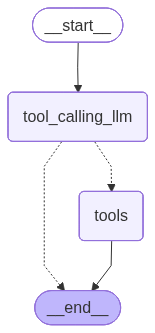

In [34]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply,add,subtract,web_search,divide]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_FiAQl7KDnCBpBixeTPamDAqt)
 Call ID: call_FiAQl7KDnCBpBixeTPamDAqt
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [38]:
messages = graph.invoke({"messages": HumanMessage(content="What is the date today? use web search")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the date today? use web search
================================== Ai Message ==================================
Tool Calls:
  web_search (call_CmE2oZHFpkUO8wNSeau0ijRH)
 Call ID: call_CmE2oZHFpkUO8wNSeau0ijRH
  Args:
    query: current date today
================================= Tool Message =================================
Name: web_search

{"query": "current date today", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.calendardate.com/todays.htm", "title": "Today's Date - CalendarDate.com", "content": "Details about today's date with count of days, weeks, and months, Sun and Moon cycles, Zodiac signs and holidays.", "score": 0.98589, "raw_content": null}, {"url": "https://www.inchcalculator.com/what-is-todays-date/", "title": "What Is Today's Date? - Inch Calculator", "content": "Today, October 15th , is day 288 of 365 total days in 2025. What is Tod

In [43]:
messages = graph.invoke({"messages": HumanMessage(content="What are the new features of python 3.14")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What are the new features of python 3.14
================================== Ai Message ==================================
Tool Calls:
  web_search (call_5UgxxIUbEnKIwxdx0pIn8WVl)
 Call ID: call_5UgxxIUbEnKIwxdx0pIn8WVl
  Args:
    query: Python 3.14 new features
================================= Tool Message =================================
Name: web_search

{"query": "Python 3.14 new features", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.pythonmorsels.com/python314/", "title": "Python 3.14's best new features", "content": "## Python 3.14: now in color! The Python REPL now includes **syntax highlighting**: Also, if you've ever wished that Python's `unittest` module included nicely colored output like `pytest`, it does now. Python 3.14 includes even more **improvements to error messages**, particularly syntax errors. One of my favorite features in Python 3.1

In [41]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 2 divided by 36?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 2 divided by 36?
================================== Ai Message ==================================
Tool Calls:
  divide (call_4mEdqAO9imcWIYkQ8B56p0YC)
 Call ID: call_4mEdqAO9imcWIYkQ8B56p0YC
  Args:
    a: 2
    b: 36
================================= Tool Message =================================
Name: divide

0.05555555555555555


### OUR EXAMPLE IN LANGGRAPH STUDIO

![image.png](attachment:7c2b0acc-030e-47e6-a75a-213950ee5442.png

Running a few prompts

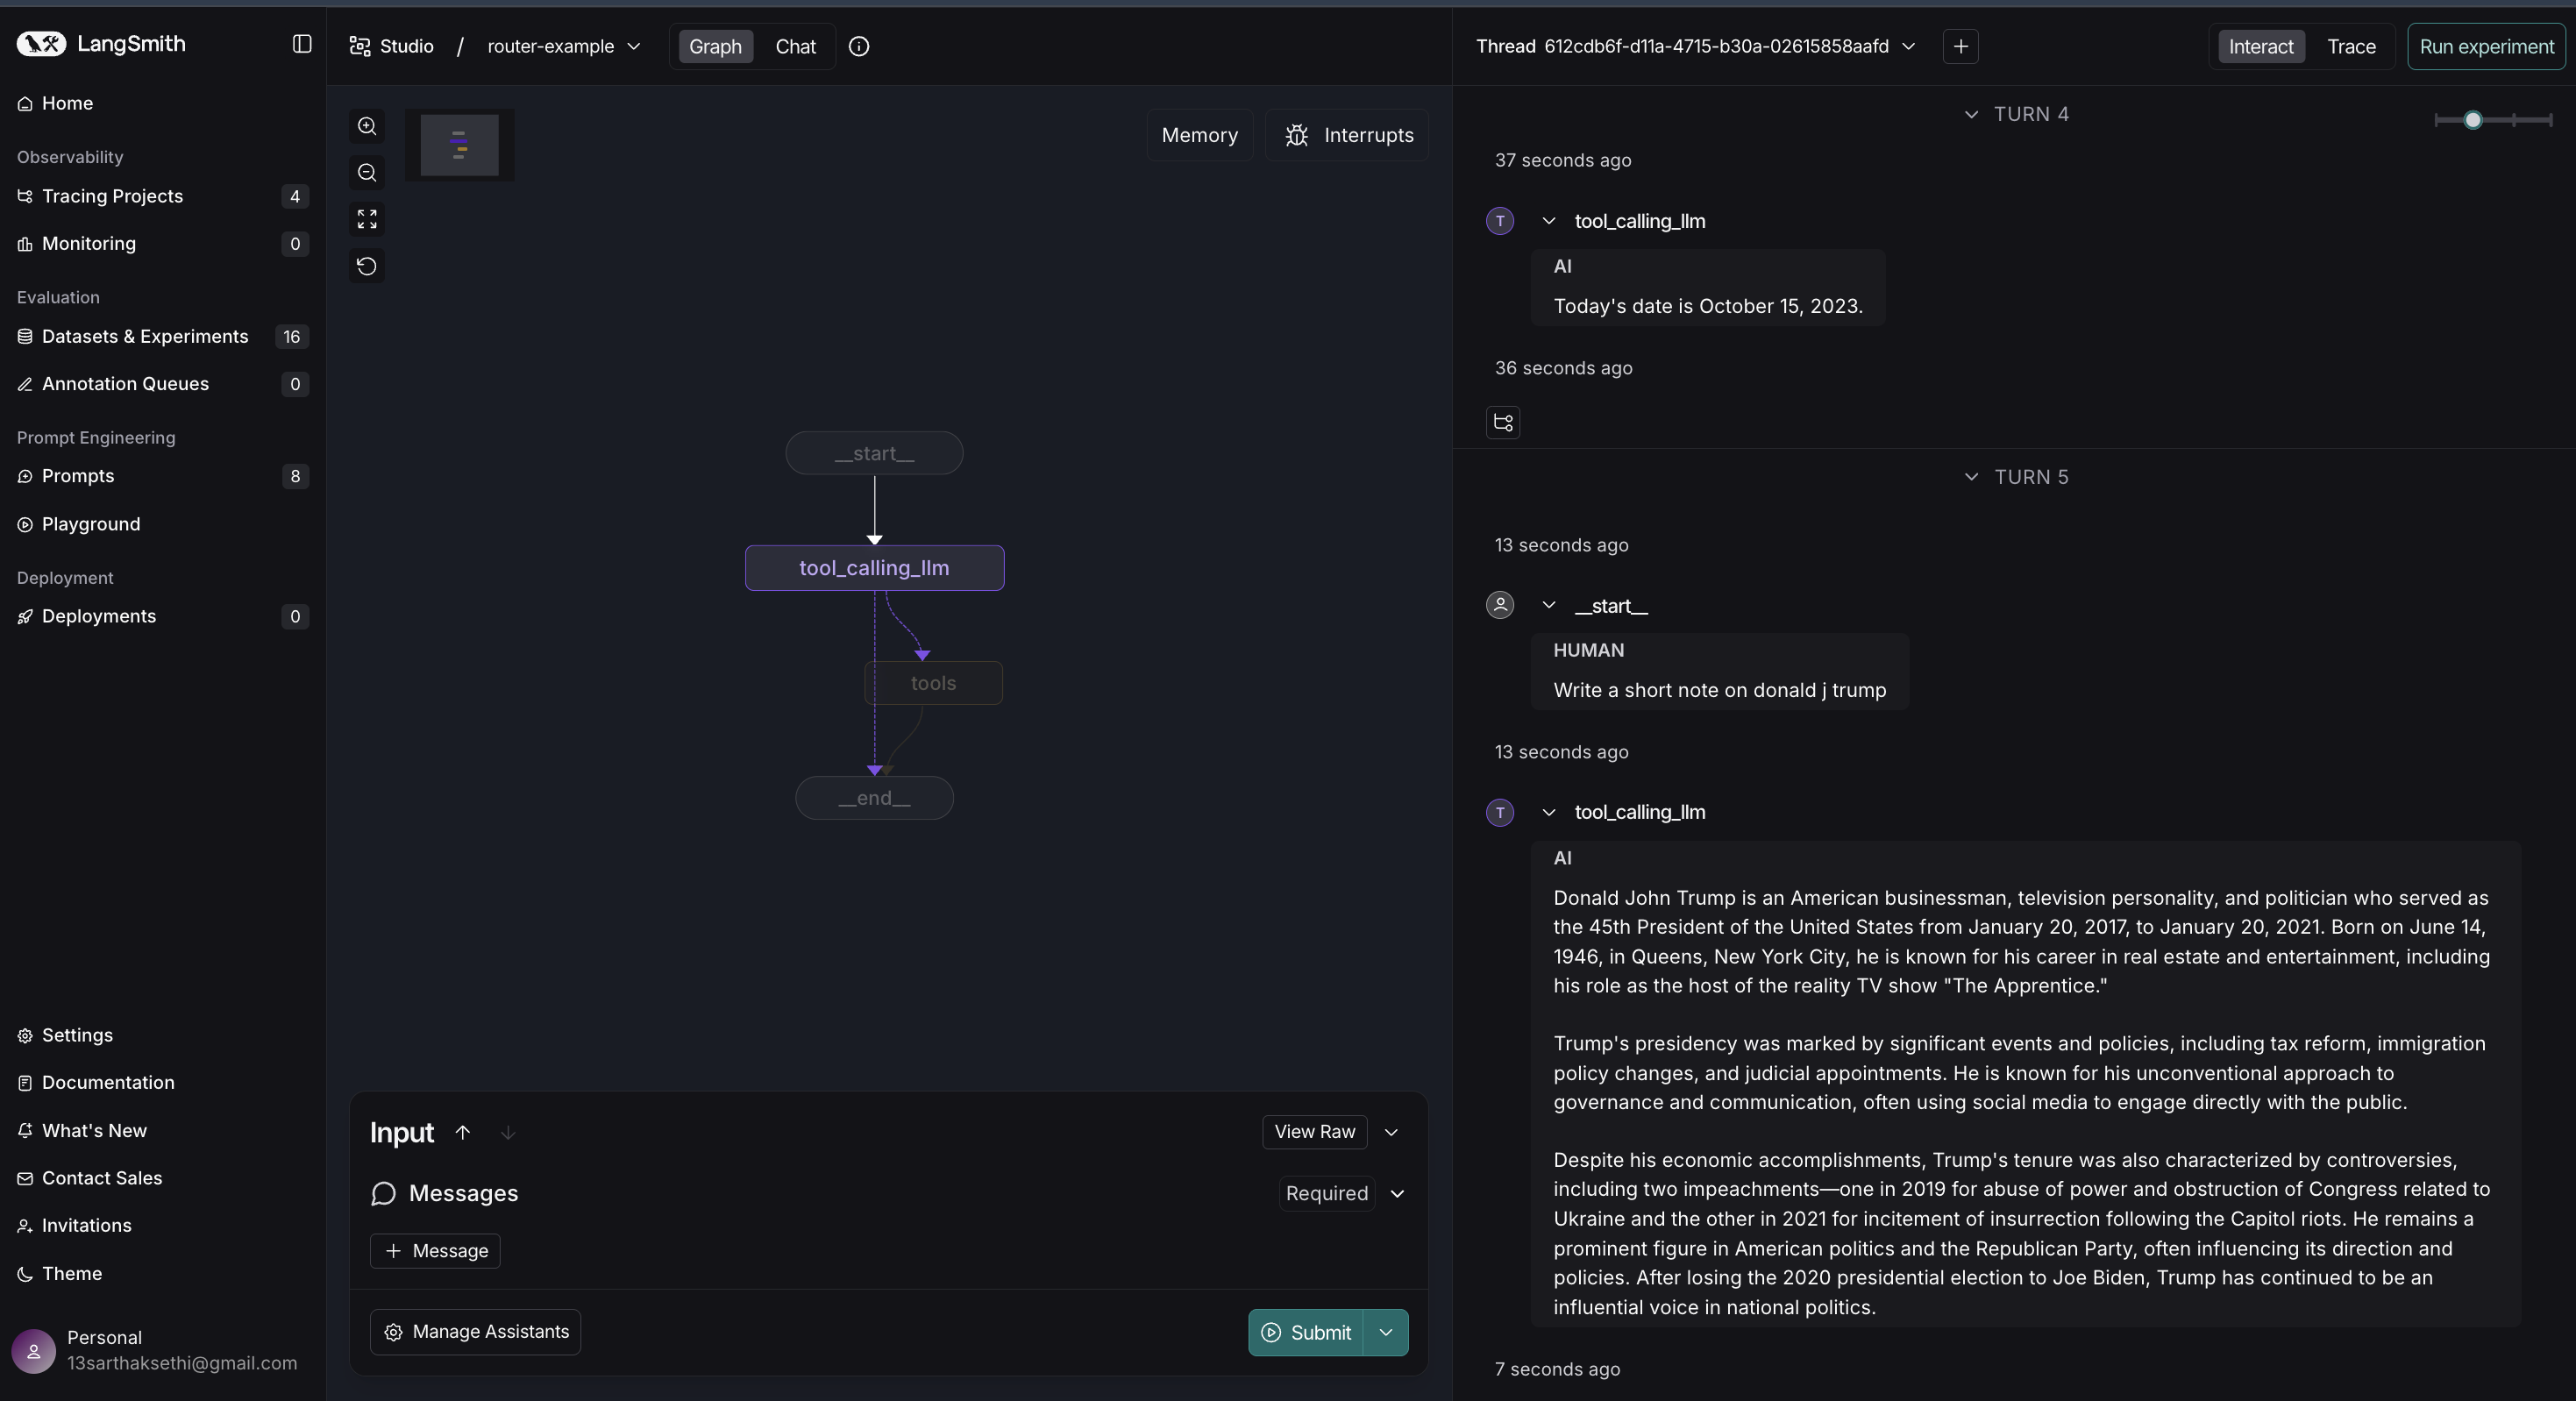

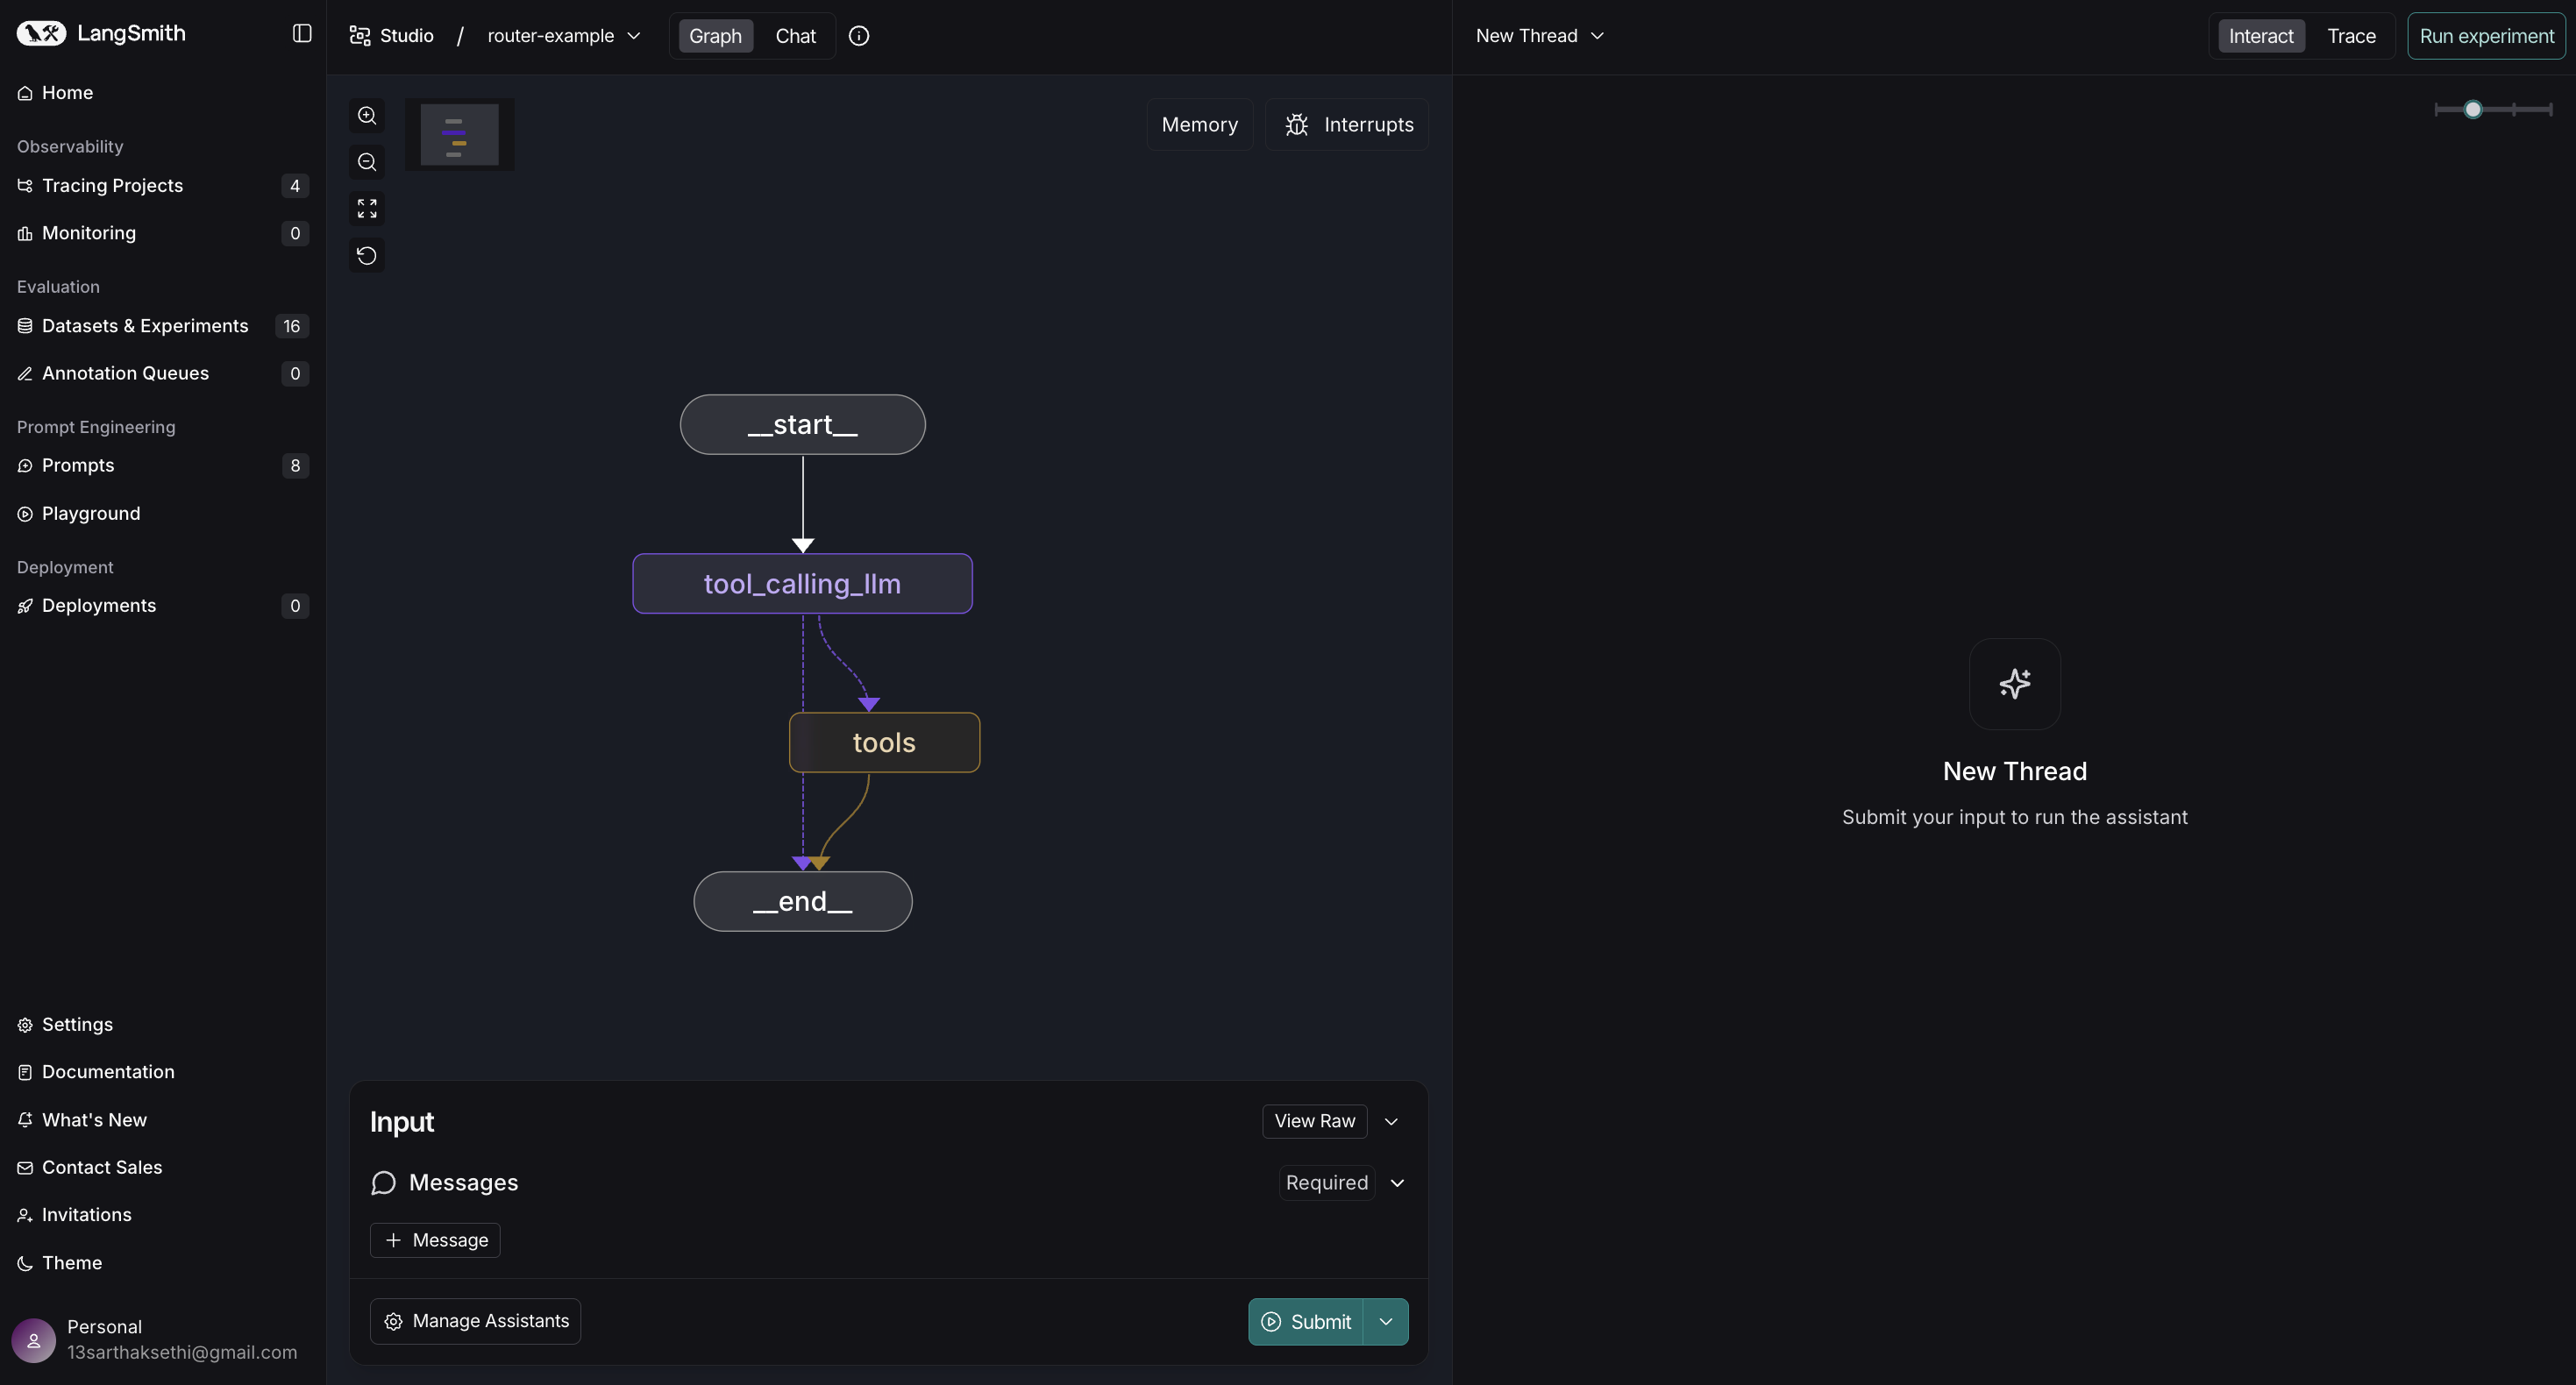